In [543]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import spacy
from collections import Counter
from math import ceil


nlp = spacy.load('en_core_web_sm')

In [421]:
def barplot(dataframe, x_attribute, y_attribute):
    sns.barplot(x=x_attribute, y=y_attribute, data=living_cost_USA_state_52, errorbar=None)
    plt.xlabel(x_attribute)
    plt.ylabel(y_attribute)
    plt.title(y_attribute + ' Index by' + x_attribute + ' compared to NY')
    plt.xticks(rotation=90)  # rotate x-axis labels by 90 degrees
    plt.show()

We first load the datasets independtly and clean them a bit.

In [2]:
# load the datasets for living cost in USA
living_cost_USA = pd.read_csv("data/living_cost_USA.csv", sep=",")

In [3]:
# load the datasets for living cost in USA by STATE
living_cost_USA_by_STATE = pd.read_csv("data/living_cost_USA_by_STATE.csv", sep=",")

In [102]:
# load the datasets for pizzas
# pizza_places = pd.read_csv("data/db_main.csv")
pizza_places = pd.read_csv("data/db_main.csv", sep=",")

In [103]:
pizza_places.columns

Index(['id', 'address', 'categories', 'city', 'country', 'keys', 'latitude',
       'longitude', 'menuPageURL', 'menus.amountMax', 'menus.amountMin',
       'menus.currency', 'menus.dateSeen', 'menus.description', 'menus.name',
       'name', 'postalCode', 'priceRangeCurrency', 'priceRangeMin',
       'priceRangeMax', 'province', 'state'],
      dtype='object')

In [403]:
pizza_places_resume = pizza_places[['name', 'menus.name', 'province', 'state', 'menus.amountMax', 'city', 'address']]

In [116]:
pizza_places_resume.sample(3)

,name,menus.name,province,state,menus.amountMax
1135,Kimono Japanese & Chinese Restaurant,Chinese Pizza,PA,Pennsylvania,4.25
2401,Mamas Pizza,Barbeque Pizza,OH,Ohio,14.20
2950,Gusto,Panini Alla Pizza,NY,New York,8.25


---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------


Now we will try to attach to construct a pizza index from theses datasets in order to make comparison between the states.

- First we have to build a mean of pizza prices by states.
- Then we can (as the bigmac_index) compare 2 states by applying the following : mean_price_A / mean_price_B
- Then, for each state we can make a mean of all it's pizza_index with all the other states. But this is not very relevant. Hence we will use the NY state as a reference to compare other states.
- Finally we can compare it to the cost of living in the USA and see how similar the results are.

In [118]:
# mean of the prices by STATE
mean_price_by_state = pizza_places_resume[['state', 'menus.amountMax']].groupby(['state']).mean().rename(columns={"menus.amountMax": "mean_price"})

In [119]:
mean_price_by_state.sample(3)

,mean_price
state,
Idaho,8.150000
Puerto Rico,8.950000
Texas,11.895913


In [120]:
mean_price_by_state_sorted = mean_price_by_state.sort_values(['mean_price'], ascending=False)

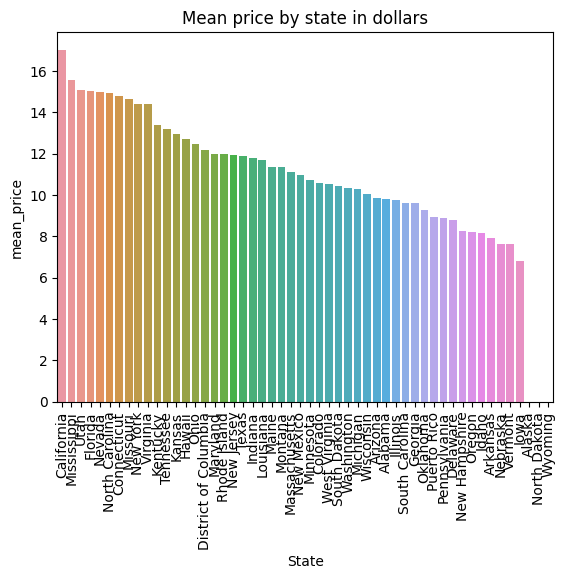

In [123]:
sns.barplot(x=mean_price_by_state_sorted.index, y='mean_price', data=mean_price_by_state_sorted, errorbar=None)
plt.xlabel('State')
plt.ylabel('mean_price')
plt.title('Mean price by state in dollars')
plt.xticks(rotation=90)  # rotate x-axis labels by 90 degrees
plt.show()

We can see that the more expensive states are Washington, Montana and Alaska.

- Now we will design a way to compute the so called pizza_index the same way as the bigmax_index.

In [124]:
def compute_pizza_index_btw_two_states(dataframe, stateA, stateB):
    A = dataframe.at[stateA, 'mean_price']
    B = dataframe.at[stateB, 'mean_price']
    return A/B

In [125]:
compute_pizza_index_btw_two_states(mean_price_by_state, "Montana", "Arizona")

1.150998945998622

In [144]:
# Compute a matrix that has all the pizza_index values

# list of all the states
state_list = mean_price_by_state.index.tolist()
state_list.remove('Alaska')
state_list.remove('Wyoming')
state_list.remove('North Dakota')
numer_of_states = len(state_list)
state_list

['Alabama',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Puerto Rico',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin']

In [145]:
# construct a matrix with theses values
pizza_index_matrix = np.zeros((numer_of_states, numer_of_states))
for i in range(numer_of_states):
    a = state_list[i]
    for j in range(numer_of_states):
        b = state_list[j]
        pizza_index_matrix[i][j] = compute_pizza_index_btw_two_states(mean_price_by_state, a, b)

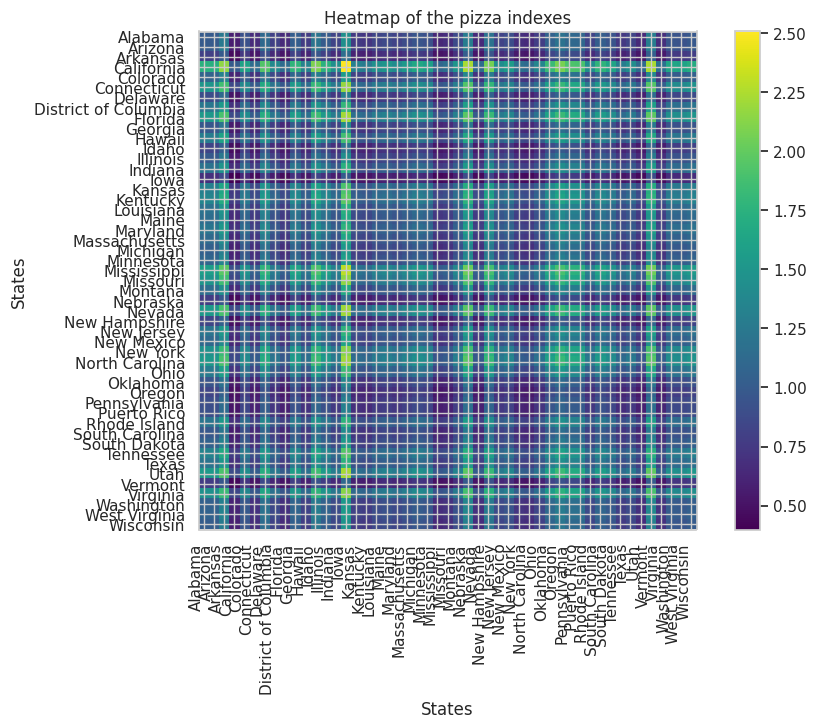

In [447]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.imshow(pizza_index_matrix, cmap='viridis')
plt.colorbar()

plt.xticks(np.arange(numer_of_states), state_list, rotation=90, ha='right')
plt.yticks(np.arange(numer_of_states), state_list)

plt.xlabel('States')
plt.ylabel('States')
plt.title('Heatmap of the pizza indexes')

plt.subplots_adjust(bottom=0.05)

plt.show()

In [445]:
pizza_index_means = []
for i in range(numer_of_states):
    mean = (pizza_index_matrix[i].sum() -1) / (numer_of_states -1)
    pizza_index_means.append(mean)

In [149]:
pizza_index = pd.DataFrame({'pizza_index': pizza_index_means}, index=state_list)

In [152]:
pizza_index.sample(3)

,pizza_index
Rhode Island,1.108607
New Mexico,1.014812
South Carolina,0.886909


In [153]:
pizza_index_sorted = pizza_index.sort_values(['pizza_index'], ascending=False)

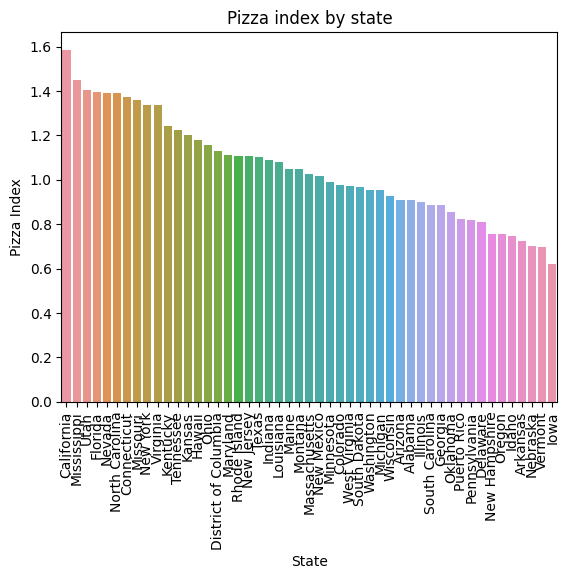

In [154]:
sns.barplot(x=pizza_index_sorted.index, y='pizza_index', data=pizza_index_sorted, errorbar=None)
plt.xlabel('State')
plt.ylabel('Pizza Index')
plt.title('Pizza index by state')
plt.xticks(rotation=90)  # rotate x-axis labels by 90 degrees
plt.show()

But having the mean of the pizza index isn't really relevant, we might aswell order by prices.
We need a baseground to compare it. As the dataset of the living cost by city has done, we are going to measure the pizza_index using the State of NewYork as the reference. This means that the pizza_index of NY will be 1.

In [156]:
NY_price = mean_price_by_state.at['New York', 'mean_price']
mean_price_by_state['pizza_index_NY'] = mean_price_by_state['mean_price']/NY_price
mean_price_by_state.dropna(inplace=True)

In [200]:
mean_price_by_state.sample(3)

,mean_price,pizza_index_NY
state,,
Oklahoma,9.294615,0.645115
Kansas,12.955294,0.899193
Illinois,9.743151,0.676247


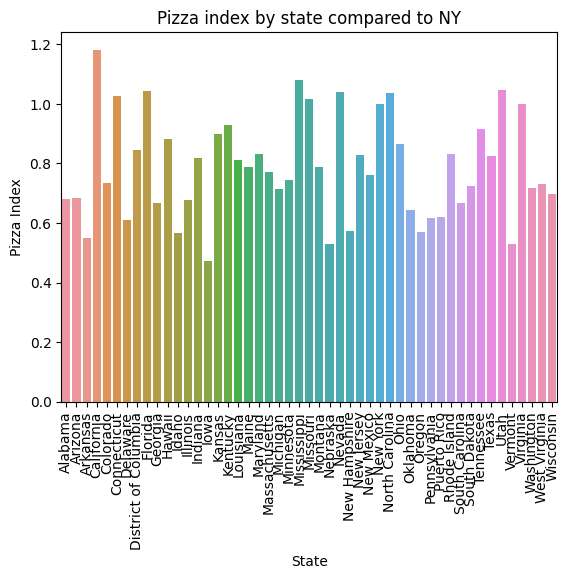

In [203]:
sns.barplot(x=mean_price_by_state.index, y='pizza_index_NY', data=mean_price_by_state, errorbar=None)
plt.xlabel('State')
plt.ylabel('Pizza Index')
plt.title('Pizza index by state compared to NY')
plt.xticks(rotation=90)  # rotate x-axis labels by 90 degrees
plt.show()

Now we have a problem with the states initiales. Indeed it's not the same for the two datasets.

In [53]:
living_cost_USA_by_STATE.sample(5)

,State,Rank,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
1,AK,16.0,93.190,39.45,67.75,96.740,78.76,138.380
40,ID,288.0,59.430,30.85,45.90,50.930,63.79,120.440
15,LA,100.0,73.610,41.21,58.27,67.000,86.02,106.740
18,GA,122.0,72.050,46.89,60.14,66.940,73.06,150.380
25,AL,205.5,65.835,31.34,49.51,64.115,64.77,134.955


In [59]:
state_list_living_cost = living_cost_USA_by_STATE['State'].tolist()

In [79]:
for state in state_list_living_cost:
    state_list_living_cost.remove(state)
    state_list_living_cost.append(state.strip())

In [162]:
# load the datasets for living cost in USA by state with 52 states
living_cost_USA_state_52 = pd.read_csv("data/dataset_living_cost_52_states.csv", sep=",")

In [164]:
state_list_living_cost_51 = living_cost_USA_state_52['State'].tolist()

In [167]:
inter = set(state_list).intersection(set(state_list_living_cost_51))

In [170]:
set(state_list_living_cost_51).difference(set(state_list))

{'Alaska', 'North Dakota', 'Wyoming'}

As we can see, the states that are not present in the dataset are : Alaska, North Dakota and Wyoming because there is no pizza with prices indicated there.

Now we want to recalibrate the living cost index around New york as opposed to Puerto Rico

In [177]:
NY_index = living_cost_USA_state_52.loc[living_cost_USA_state_52['State'] == 'New York', 'Index'].values[0]

In [179]:
adjustement_factor = 100.0/NY_index
living_cost_USA_state_52['Index'] = living_cost_USA_state_52['Index'] * adjustement_factor

We first calculate the adjustment factor for the Index column to make the New York Index value equal to 100.0. Then, we adjust the other columns by multiplying each value with the ratio of the current row's Index value to the New York Index value. This ensures that the relationships and proportions between the columns are maintained while recalibrating the values.

In [181]:
columns_to_adjust = ['Grocery', 'Housing', 'Utilities', 'Transportation', 'Health', 'Misc.']
for column in columns_to_adjust:
    living_cost_USA_state_52[column] = living_cost_USA_state_52[column] * (living_cost_USA_state_52['Index'] / NY_index)

In [183]:
living_cost_USA_state_52.sample(3)

,Rank,State,Initials,Index,Grocery,Housing,Utilities,Transportation,Health,Misc.
15,16,Wyoming,WY,79.467354,70.455592,56.255240,56.323511,66.768962,65.540086,66.154524
50,51,Maryland,MD,113.316151,110.492982,124.998229,107.085710,124.998229,124.998229,129.671060
39,40,Washington,WA,98.109966,91.451300,106.201509,74.509630,96.171367,101.650016,95.328498


In [187]:
living_cost_USA_state_52 = living_cost_USA_state_52.sort_values('State')

In [189]:
states_to_remove = ['Wyoming', 'North Dakota', 'Alaska']
mask = ~living_cost_USA_state_52['State'].isin(states_to_remove)
living_cost_USA_state_52 = living_cost_USA_state_52[mask]

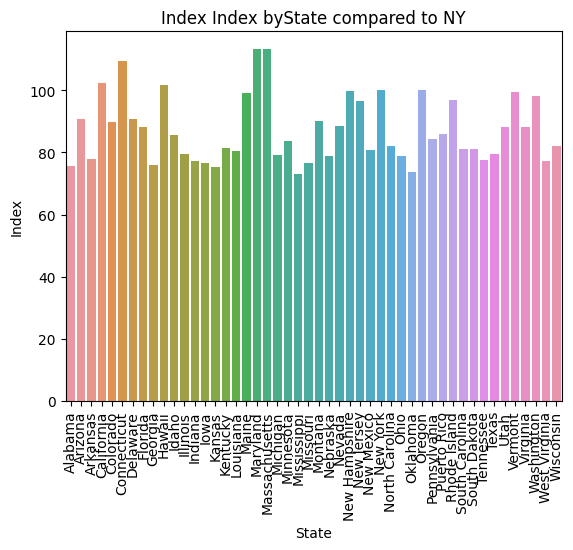

In [195]:
barplot(living_cost_USA_state_52, 'State', 'Index')

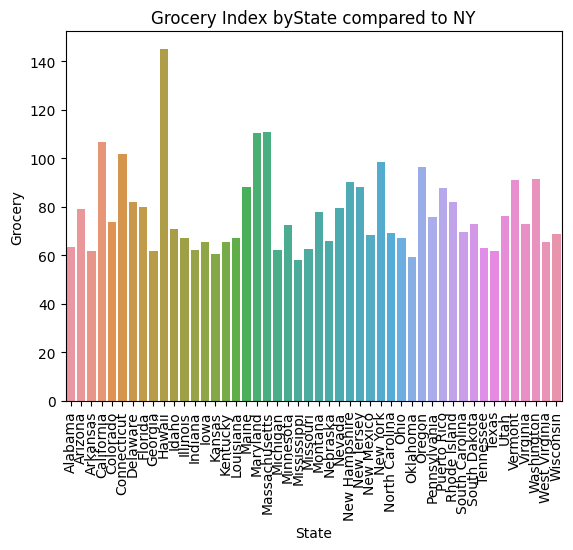

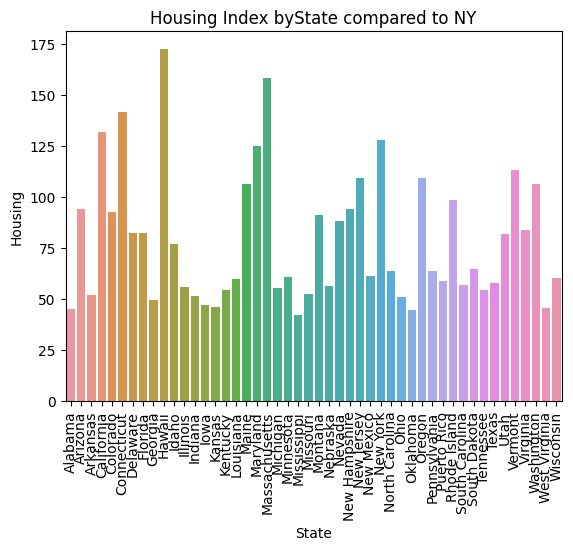

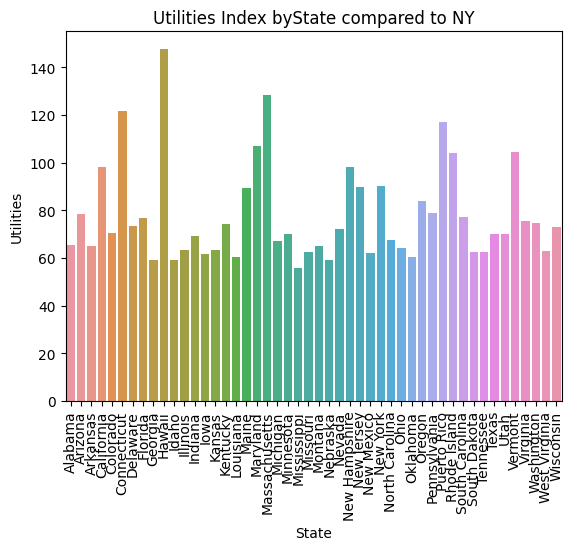

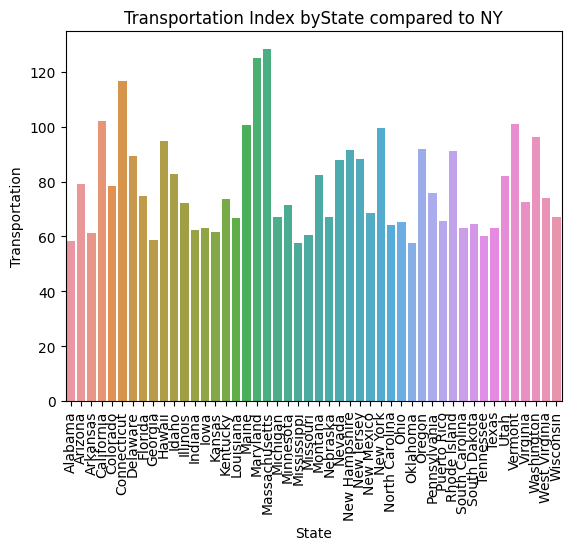

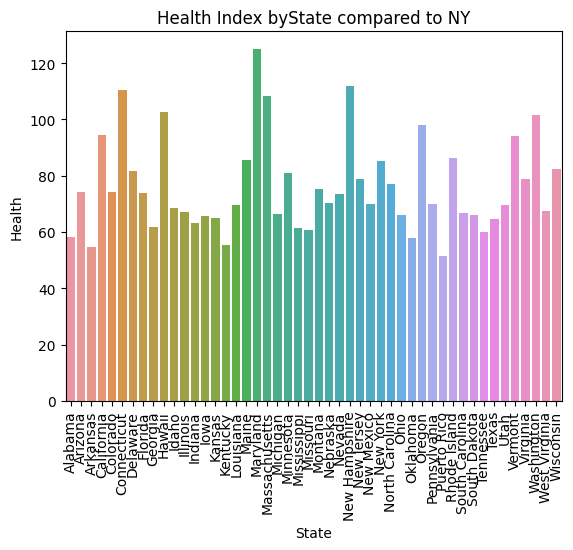

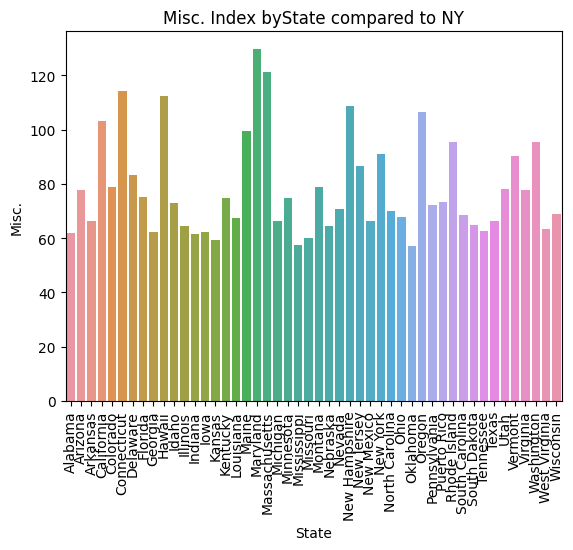

In [198]:
for col in columns_to_adjust:
    barplot(living_cost_USA_state_52, 'State', col)

Now it's time to merge these dataframes?
And calculate how far from the the social dataset the pizza index is.

In [204]:
merged_df = living_cost_USA_state_52.merge(mean_price_by_state, left_on='State', right_index=True)

In [206]:
merged_df['pizza_index_NY'] = merged_df['pizza_index_NY'] * 100

In [208]:
merged_df.sample(3)

,Rank,State,Initials,Index,Grocery,Housing,Utilities,Transportation,Health,Misc.,mean_price,pizza_index_NY
39,40,Washington,WA,98.109966,91.451300,106.201509,74.509630,96.171367,101.650016,95.328498,10.350625,71.840999
35,36,Delaware,DE,90.721649,82.070358,82.070358,73.497006,89.318737,81.836539,83.317391,8.800000,61.078514
12,13,Nebraska,NE,78.951890,66.064554,56.297310,59.078261,67.081975,70.134239,64.301024,7.643750,53.053283


In [214]:
mse = {}
target_col = 'pizza_index_NY'
other_cols = ['Index', 'Grocery', 'Housing', 'Utilities', 'Transportation', 'Health', 'Misc.']

for col in other_cols:
    mse[col] = np.mean((merged_df[target_col] - merged_df[col]) ** 2)

mse_df = pd.DataFrame.from_dict(mse, orient='index', columns=['Mean Squared Error'])

In [215]:
mse_df

,Mean Squared Error
Index,430.130607
Grocery,501.357696
Housing,1073.412849
Utilities,632.324249
Transportation,525.833917
Health,528.777309
Misc.,556.072903


Now we are going to see if many pizza have ingredients.

In [678]:
pizza_with_ingredients = pizza_places[['name', 'menus.name', 'state', 'menus.description', 'latitude', 'longitude', 'address', 'city', 'menus.amountMax']]

In [679]:
pizza_with_ingredients.sample(3)

,name,menus.name,state,menus.description,latitude,longitude,address,city,menus.amountMax
434,Euro Pizzeria,Pizza Primavera,New York,"Spinach, Eggplant, Sliced Tomato and Mushrooms",41.028360,-73.766540,120 E Post Rd,White Plains,18.99
2116,Wolfgang Puck Bar & Grill - Summerlin,Pepperoni Pizza,Nevada,"mozzarella, red onion, san marzano tomatoes",36.126289,-115.326772,10955 Oval Park Dr,Las Vegas,15.00
2719,The Firehouse,Kids Pizza,New Jersey,NaN,40.885036,-74.109283,42 Plauderville Ave,Garfield,4.95


In [680]:
len(pizza_with_ingredients)

3510

In [681]:
nan_proportion = pizza_with_ingredients['menus.description'].isna().mean()

In [682]:
nan_proportion

0.5652421652421652

In [683]:
pizza_with_ingredients.dropna(inplace=True)

/tmp/ipykernel_2765656/1016171750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizza_with_ingredients.dropna(inplace=True)


In [684]:
len(pizza_with_ingredients)

1225

In [685]:
pizza_with_ingredients.sample(3)

,name,menus.name,state,menus.description,latitude,longitude,address,city,menus.amountMax
2587,Di Nardo's Ristorante Italiano,Hawaiian Pizza,New York,"Ham, pineapple, tomato, cheese",41.188130,-73.549477,76 Westchester Ave,Pound Ridge,23.00
974,City Pizza,Greek Combo Pizza,New York,"Gyros meat, olives, onions, oregano, fresh tom...",42.936360,-74.189180,1370 Riverfront Ctr,Amsterdam,6.49
2196,Trattoria Il Mulino - Nashville,Margherita Pizza,Tennessee,"mozzarella, tomatoes",36.159201,-86.777574,144 Fifth Ave S,Nashville,17.00


In [686]:
pizza_with_ingredients.rename(columns={"menus.description": "ingredients"}, inplace=True)

/tmp/ipykernel_2765656/2285400061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizza_with_ingredients.rename(columns={"menus.description": "ingredients"}, inplace=True)


In [687]:
def preprocess_ingredients(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(lemmas)

In [688]:
pizza_with_ingredients['ingredients'] = pizza_with_ingredients['ingredients'].apply(preprocess_ingredients)

/tmp/ipykernel_2765656/283651041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizza_with_ingredients['ingredients'] = pizza_with_ingredients['ingredients'].apply(preprocess_ingredients)


In [689]:
pizza_with_ingredients['ingredients'] = pizza_with_ingredients['ingredients'].apply(lambda x : x.split(", "))

/tmp/ipykernel_2765656/267450261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizza_with_ingredients['ingredients'] = pizza_with_ingredients['ingredients'].apply(lambda x : x.split(", "))


In [690]:
def remove_punctuation(word):
    doc = nlp(word)
    no_punct_word = ''.join(token.text for token in doc if not token.is_punct or token.is_space)
    return no_punct_word

In [691]:
not_food_item = ['.', 'fresh', 'top', 'red', 'green', 'black', 'roasted', 'grill', 'italian', 'slice', 'topping', 'extra', 'blend', 'white', '(', ')', 'homemade', 'choice', 'canadian', 'serve', 'smoke', 'hot', 'chop', 'roma', 'include', 'bell', 'traditional', 'house', 'bake', 'classic', 'drizzle', 'large', 'create', '2', 'dressing', 'cover', 'style', 'special', 'sauteed', 'ranch', 'specialty', 'sliced', 'shred', 'hand']

In [692]:
def strip_lower_list(liste):
    ret = []
    for word in liste:
        # no_punct_word = remove_punctuation(word)
        list_word = word.lower().strip().split()
        for w in list_word:
            if w not in not_food_item:
                ret.append(w)
    return ret

In [693]:
pizza_with_ingredients['ingredients'] = pizza_with_ingredients['ingredients'].apply(lambda x : strip_lower_list(x))

/tmp/ipykernel_2765656/778145286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizza_with_ingredients['ingredients'] = pizza_with_ingredients['ingredients'].apply(lambda x : strip_lower_list(x))


In [694]:
pizza_with_ingredients.sample(1)

,name,menus.name,state,ingredients,latitude,longitude,address,city,menus.amountMax
2665,Sicilia's Pizzeria,Fare Soldi Gourmet Stuffed Pizza,West Virginia,"[artichoke, heart, olive, garlic, mozzarella, ...",40.399185,-80.59096,3601 Main St,Weirton,7.99


In [695]:
word_counter = Counter()

for ingredients in pizza_with_ingredients['ingredients']:
    if isinstance(ingredients, list):
        word_counter.update(ingredients)

for word, count in word_counter.most_common():
    print(word, count)

cheese 549
mozzarella 509
sauce 429
tomato 344
onion 300
pepper 222
olive 186
chicken 185
garlic 184
pizza 176
mushroom 171
pepperoni 166
basil 137
bacon 125
sausage 116
parmesan 82
ham 81
oil 75
spinach 72
ricotta 65
bbq 62
pineapple 56
cheddar 56
beef 52
oregano 50
broccoli 46
provolone 46
artichoke 43
marinara 41
feta 36
alfredo 34
pesto 34
arugula 32
crust 31
buffalo 30
steak 30
breast 29
eggplant 29
spicy 29
meatball 26
cilantro 26
goat 25
prosciutto 24
heart 23
salami 23
shrimp 23
melt 21
sweet 20
egg 20
ground 19
meat 18
deep 17
caramelize 17
zucchini 16
fry 16
kalamata 16
honey 16
b.b.q 16
romano 15
bleu 15
lettuce 15
banana 15
gorgonzola 14
tortilla 14
chunk 14
marinated 13
jalapeno 13
creamy 13
gouda 13
bread 13
scallion 13
balsamic 13
dough 13
fontina 13
freshly 12
butter 12
crispy 12
tender 12
salad 12
request 12
toss 12
french 12
smoked 12
fried 11
medium 11
touch 11
thin 11
spice 11
tomatoe 10
bean 10
original 10
stuff 10
cream 10
blue 10
baby 10
roll 10
american 10
5 10


In [696]:
threshold = 25
filtered_counter = {word: count for word, count in word_counter.items() if count >= threshold}

In [697]:
data = {'Word': list(filtered_counter.keys()), 'Count': list(filtered_counter.values())}
df_word_count = pd.DataFrame(data)

In [698]:
#df_word_count = df_word_count[~df_word_count['word'].isin(not_food_item)]

In [699]:
df_word_count = df_word_count.sort_values('Count', ascending=False)

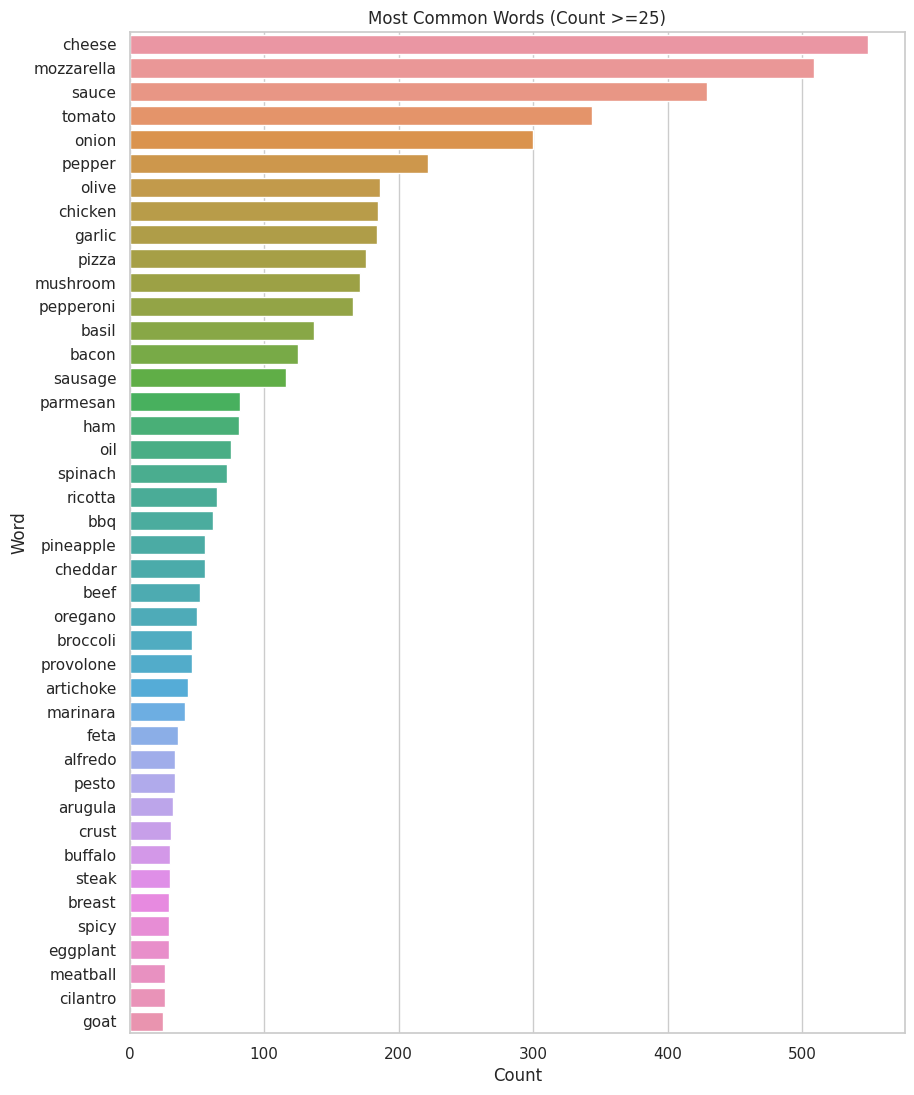

In [700]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 13))
sns.barplot(x='Count', y='Word', data=df_word_count)
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Most Common Words (Count >=' + str(threshold) + ')')
plt.show()

In [702]:
pizza_with_ingredients.sample(1)

,name,menus.name,state,ingredients,latitude,longitude,address,city,menus.amountMax
2525,Galaxy Restaurant Inc,3 Cheese Pizza,Ohio,"[mozzarella, cheddar, parmesan, marinara, sauce]",40.03056,-83.15628,5240 Cemetery Rd,Hilliard,8.75


In [ ]:
# SAVE the PIZZA INGREDIENT DATABASE FOR THE QUERY
pizza_with_ingredients.to_csv('pizza_with_ingredients.csv')

In [703]:
# function that allows to query the pizza_ingredient dataset to locate the restaurants that could prepare this pizza
def search_pizza(ingredients_list, pizza_df, percentage):
    ingredients = []
    for word in ingredients_list:
        ingredients.append(word.lower())
        
    # percentage% ingredient coverage
    filtered_pizzas = pizza_df[pizza_df['ingredients'].apply(lambda x: sum(item in x for item in ingredients) >= ceil(percentage * len(ingredients)))]
    print('We have found ' + str(len(filtered_pizzas)) + ' places where you can buy this pizza !')
    return filtered_pizzas

In [713]:
food_items = ['pineapple', 'broccoli', 'cheese']
search_pizza(food_items, pizza_with_ingredients, 0.99)

We have found 3 places where you can buy this pizza !


,name,menus.name,state,ingredients,latitude,longitude,address,city,menus.amountMax
61,Keyme,Pizza Toppings,Washington,"[pepperoni, sausage, ground, western, beef, co...",47.413195,-122.218841,21100 91st Pl S,Kent,1.75
417,Pie In The Sky,Cheese Pizza,Vermont,"[garlic, charge, carrot, bacon, mushroom, onio...",44.838036,-73.081566,267 Swanton Rd,Saint Albans,6.95
810,Joey Nova's Pizzeria and Grilled Subs,Additional Toppings Cheese Pizza,Minnesota,"[pepperoni, onion, banana, pepper, bacon, arti...",44.901255,-93.588643,5655 Manitou Rd,Excelsior,1.50


Now we are going to work more precisely on the New York state.

In [456]:
living_cost_USA['State'] = living_cost_USA['State'].apply(lambda x: x.strip())

In [515]:
def cities_in_state(state):
    cities_in_state = living_cost_USA[living_cost_USA['State'] == state].copy()
    cities_in_state.loc[:, 'City'] = cities_in_state['City'].apply(lambda x: x.split(', ')[0])
    cities_in_state.rename(columns={"City": "city"}, inplace=True)
    
    return cities_in_state

In [516]:
def pizza_in_state(state):
    pizza_state = pizza_places_resume[pizza_places_resume['state'] == state].copy()
    pizza_state.dropna(inplace=True)
    #pizza_state['province'] = pizza_NY['province'].apply(lambda x: x.lower())
    pizza_state.groupby(['city'], as_index=False).mean(numeric_only=True)
    pizza_state.rename(columns={"menus.amountMax": "mean_price"}, inplace=True)
    
    sns.barplot(x='city', y='mean_price', data=pizza_state, errorbar=None)
    plt.xlabel('City')
    plt.ylabel('Mean price')
    plt.title('Mean price by city in dollars in the ' + state + ' state')
    plt.xticks(rotation=90)  # rotate x-axis labels by 90 degrees
    plt.tight_layout()
    plt.show()
    
    return pizza_state

In [559]:
def pizza_state_cities(city, initiales, plot:bool):
    pizza = pizza_in_state(city)
    cities = cities_in_state(initiales)
    
    pizza = pizza.groupby(['city']).mean(numeric_only=True)
    
    pizza_cities = cities.merge(pizza, on='city', how='inner')
    
    if plot:
        sns.barplot(x='city', y='mean_price', data=pizza_cities, errorbar=None)
        plt.xlabel('City')
        plt.ylabel('Mean_price')
        plt.title('Mean price by city in the ' + initiales + ' state')
        plt.xticks(rotation=90)  # rotate x-axis labels by 90 degrees
        plt.show()
        
    return pizza_cities

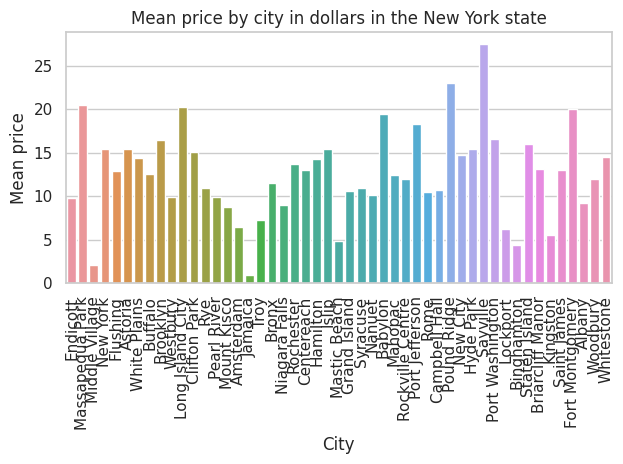

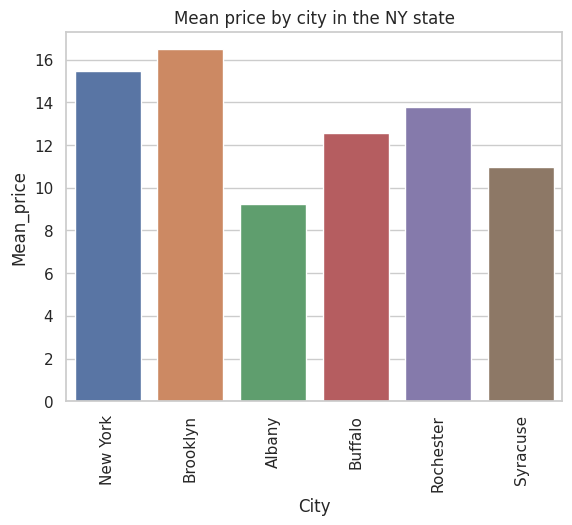

In [561]:
pizza_cities_NY = pizza_state_cities('New York', 'NY', True)

In [567]:
pizza_cities_NY.sample(5)

,Unnamed: 0,Rank,city,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Location,State,mean_price
0,11,12,New York,100.00,100.00,100.00,100.00,100.00,100.00,"['New York', ' NY', ' United States']",NY,15.457875
1,16,17,Brooklyn,90.31,81.02,85.91,83.16,95.27,87.05,"['Brooklyn', ' NY', ' United States']",NY,16.475000
4,146,147,Rochester,70.25,30.81,51.58,69.88,71.98,91.12,"['Rochester', ' NY', ' United States']",NY,13.762000
2,41,42,Albany,79.38,31.01,56.48,77.50,77.64,108.77,"['Albany', ' NY', ' United States']",NY,9.250000
3,139,140,Buffalo,70.59,29.30,51.04,62.31,72.75,111.16,"['Buffalo', ' NY', ' United States']",NY,12.553750


In [568]:
NY_price = pizza_cities_NY[pizza_cities_NY['city'] == 'New York']['mean_price'].values[0]
pizza_cities_NY['pizza_index_NY'] = pizza_cities_NY['mean_price']/NY_price * 100

In [571]:
def mse_pizza(dataframe, target_col, other_cols):
    mse = {}
    for col in other_cols:
        mse[col] = np.mean((dataframe[target_col] - dataframe[col]) ** 2)
    
    return pd.DataFrame.from_dict(mse, orient='index', columns=['Mean Squared Error'])

In [572]:
target_col = 'pizza_index_NY'
other_cols = ['Cost of Living Index', 'Rent Index', 'Groceries Index', 'Restaurant Price Index', 'Local Purchasing Power Index']

mse_pizza(pizza_cities_NY, target_col, other_cols)

,Mean Squared Error
Cost of Living Index,6353.207548
Rent Index,3317.829354
Groceries Index,5829.561742
Restaurant Price Index,6574.760828
Local Purchasing Power Index,9682.718663
